(lecture06:selecting-rows)=
# Selecting dataframe rows that satisfy a boolean expression

We are now going to put to use what we learned about Python boolean expressions to extract rows from a dataframe that satisfy certain criteria.

## Extract rows that satisfy single boolean expression

Let's do this by example.
Let's load again the `temperature_raw.xlsx` dataset we played with in {ref}`lecture05:models-are-functions`.

In [56]:
MAKE_BOOK_FIGURES=False

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks")

def set_book_style():
    plt.style.use('seaborn-v0_8-white') 
    sns.set_style("ticks")
    sns.set_palette("deep")

    mpl.rcParams.update({
        # Font settings
        'font.family': 'serif',  # For academic publishing
        'font.size': 8,  # As requested, 10pt font
        'axes.labelsize': 8,
        'axes.titlesize': 8,
        'xtick.labelsize': 7,  # Slightly smaller for better readability
        'ytick.labelsize': 7,
        'legend.fontsize': 7,
        
        # Line and marker settings for consistency
        'axes.linewidth': 0.5,
        'grid.linewidth': 0.5,
        'lines.linewidth': 1.0,
        'lines.markersize': 4,
        
        # Layout to prevent clipped labels
        'figure.constrained_layout.use': True,
        
        # Default DPI (will override when saving)
        'figure.dpi': 600,
        'savefig.dpi': 600,
        
        # Despine - remove top and right spines
        'axes.spines.top': False,
        'axes.spines.right': False,
        
        # Remove legend frame
        'legend.frameon': False,
        
        # Additional trim settings
        'figure.autolayout': True,  # Alternative to constrained_layout
        'savefig.bbox': 'tight',    # Trim when saving
        'savefig.pad_inches': 0.1   # Small padding to ensure nothing gets cut off
    })

def save_for_book(fig, filename, is_vector=True, **kwargs):
    """
    Save a figure with book-optimized settings.
    
    Parameters:
    -----------
    fig : matplotlib figure
        The figure to save
    filename : str
        Filename without extension
    is_vector : bool
        If True, saves as vector at 1000 dpi. If False, saves as raster at 600 dpi.
    **kwargs : dict
        Additional kwargs to pass to savefig
    """    
    # Set appropriate DPI and format based on figure type
    if is_vector:
        dpi = 1000
        ext = '.pdf'
    else:
        dpi = 600
        ext = '.tif'
    
    # Save the figure with book settings
    fig.savefig(f"{filename}{ext}", dpi=dpi, **kwargs)


def make_full_width_fig():
    return plt.subplots(figsize=(4.7, 2.9), constrained_layout=True)

def make_half_width_fig():
    return plt.subplots(figsize=(2.35, 1.45), constrained_layout=True)

if MAKE_BOOK_FIGURES:
    set_book_style()
make_full_width_fig = make_full_width_fig if MAKE_BOOK_FIGURES else lambda: plt.subplots()
make_half_width_fig = make_half_width_fig if MAKE_BOOK_FIGURES else lambda: plt.subplots()

In [57]:
!curl -O 'https://raw.githubusercontent.com/PurdueMechanicalEngineering/me-239-intro-to-data-science/master/data/temperature_raw.xlsx'

import pandas as pd
df = pd.read_excel('temperature_raw.xlsx')
df = df.dropna(axis=0)
df.date = pd.to_datetime(df['date'], format='%Y-%m-%d')
df.head()

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  277k  100  277k    0     0   937k      0 --:--:-- --:--:-- --:--:--  939k


household       date  score     t_out     t_unit        hvac
0        a1 2018-01-07  100.0  4.283373  66.693229  246.473231
1       a10 2018-01-07  100.0  4.283373  66.356134    5.492116
2       a11 2018-01-07   58.0  4.283373  71.549132  402.094327
3       a12 2018-01-07   64.0  4.283373  73.429514  211.692244
4       a13 2018-01-07  100.0  4.283373  63.923937    0.850536

Recall that we made a simple model between the weekly average of the consumed energy in kWh `hvac` and the average weekly external temperature `t_out`.
The model was:

In [58]:
def hvac_model(t_out, a, b, t_out_min=60):
    """
    A naïve model of weekly HVAC energy consumption (kWh) as a function of external temperature t_out.
    The mathematical form of the model is:
    
        hvac = a * (t_out - t_out_min)^2 + b
    
    Arguments:
    t_out      -   The average external temperature in degrees F (average over a week).
    a          -   A parameter to be calibrated using observed data. In units of kWh / (deg F)^2.
    b          -   Another parameter to be calibrated using observed data. This is in units of kWh.
                   It is the energy consumption when the HVAC system is not used.
    t_out_min  -   The external temperature above at which the occupants feel comfortable without using
                   their HVAC system.
    
    Returns: The weekly HVAC energy consumption in kWh.
    """
    return a * (t_out - t_out_min) ** 2 + b

and the predictions looked like this:

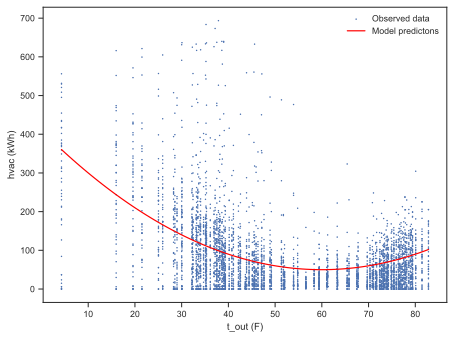

In [59]:
import numpy as np

a = 0.1 # in kWh / F^2
b = 50 # in kWh
fig, ax = make_full_width_fig()

# First the scatter plot of all the data we have
ax.scatter(df['t_out'], df['hvac'], label='Observed data', s=0.5)
ax.set_xlabel('t_out (F)')
ax.set_ylabel('hvac (kWh)')

# Now pick some temperatures to use our model on:
t_outs = np.linspace(df['t_out'].min(), df['t_out'].max(), 100)
predicted_hvac = hvac_model(t_outs, a, b)
ax.plot(t_outs, predicted_hvac, 'r', label='Model predictons')
plt.legend(loc='best');

Clearly, this model represents some sort of average behavior.
Let's use see how specific households perform.
Here is how many households we have:

In [60]:
df['household'].unique()

array(['a1', 'a10', 'a11', 'a12', 'a13', 'a16', 'a2', 'a3', 'a4', 'a5',
       'a6', 'a7', 'a8', 'a9', 'b17', 'b18', 'b19', 'b20', 'b21', 'b22',
       'b23', 'b24', 'b25', 'b26', 'b28', 'b29', 'b30', 'b31', 'b33',
       'c34', 'c35', 'c36', 'c37', 'c38', 'c39', 'c40', 'c41', 'c42',
       'c43', 'c44', 'c45', 'c46', 'c47', 'c48', 'c49', 'c50', 'a15',
       'a14', 'b32', 'b27'], dtype=object)

How can we extract the data for say household `a1`?
You can do it as follows.
First, notice that you can use a boolean expression directly on the column `household`.
The result is an an array with `True` or `False` indicating the value of the boolean expression on the corresponding rows.
Here it is:

In [61]:
df['household'] == 'a1'

0        True
1       False
2       False
3       False
4       False
        ...  
5643    False
5644    False
5646    False
5647    False
5649    False
Name: household, Length: 4887, dtype: bool

Now, if you feed this array of booleans to the dataframe, it will understand that you only want to keep the rows that are `True`.
Here it is:

In [62]:
df[df['household'] == 'a1'].round(2)

household       date  score  t_out  t_unit    hvac
0           a1 2018-01-07  100.0   4.28   66.69  246.47
50          a1 2018-01-14   98.0  33.44   67.81  116.95
100         a1 2018-01-21  100.0  19.58   66.51  116.13
150         a1 2018-01-28   96.0  41.08   69.58   61.09
200         a1 2018-02-04   96.0  30.07   70.09   61.35
...        ...        ...    ...    ...     ...     ...
4700        a1 2019-10-27   97.0  54.83   73.62    8.56
4750        a1 2019-11-03   98.0  45.93   72.46   14.33
4800        a1 2019-11-10   97.0  40.18   72.45   10.76
4850        a1 2019-11-17   99.0  32.20   71.45   11.83
4900        a1 2019-11-24   97.0  39.33   70.90    8.46

[82 rows x 6 columns]

So, there are 82 rows corresponding to this household.
If you wanted to find rows of another household, say `b17`, you do this:

In [63]:
df[df['household'] == 'b17'].round(2)

household       date  score  t_out  t_unit    hvac
16         b17 2018-01-07   73.0   4.28   74.91  330.89
66         b17 2018-01-14   70.0  33.44   75.11  163.87
116        b17 2018-01-21   69.0  19.58   74.96  296.65
166        b17 2018-01-28   70.0  41.08   74.63  146.17
216        b17 2018-02-04   79.0  30.07   74.34  244.35
...        ...        ...    ...    ...     ...     ...
5416       b17 2020-02-02   92.0  33.66   70.94  101.67
5466       b17 2020-02-09   95.0  38.12   71.55  109.25
5516       b17 2020-02-16   92.0  28.55   71.43  182.11
5566       b17 2020-02-23   92.0  33.93   69.29  139.91
5616       b17 2020-02-25   95.0  43.64   72.25    8.29

[113 rows x 6 columns]

So, we have 113 rows for household `b17`.
The difference in the entries is likely due to sensor malfunction.
Now, let's redo our scatter plot but using different colors for `a1` and `b17`.

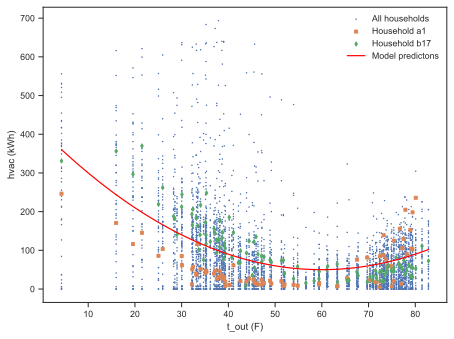

In [64]:
fig, ax = make_full_width_fig()

ax.scatter(df['t_out'], df['hvac'], label='All households', s=0.5)

# Do the scatter plot for a1
a1_df = df[df['household'] == 'a1']
ax.scatter(a1_df['t_out'], a1_df['hvac'], label='Household a1', s=10, marker='s')
# and the scatter plot for b17
b17_df = df[df['household'] == 'b17']
ax.scatter(b17_df['t_out'], b17_df['hvac'], label='Household b17', s=10, marker='d')

# The labels
ax.set_xlabel('t_out (F)')
ax.set_ylabel('hvac (kWh)')

# Plot also our model.
predicted_hvac = hvac_model(t_outs, a, b)
ax.plot(t_outs, predicted_hvac, 'r', label='Model predictons')
plt.legend(loc='best')

save_for_book(fig, 'ch6.fig1');

Notice the difference in behavior between the two households.
Household `a1` is using less energy during the heating season, but more during the cooling season.

### Questions

+ Modify the plot above to add data from household `c36`. 

## Plotting timeseries data

Since we have extracted the data for units `a1` and `b17`, we have a good opportunity to demonstrate another set of useful plots that you can do with dataframes.
We can now plot `t_unit` as a function of the `date` for each one of these units.
Let's do it step by step.
First, see this plot:

<Axes: xlabel='date'>

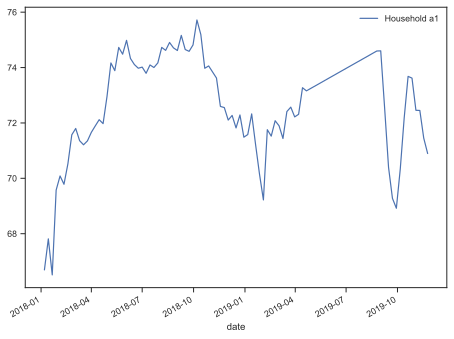

In [65]:
fig, ax = plt.subplots()
a1_df.plot(x='date', y='t_unit', label='Household a1', ax=ax)

Now, there are some data missing during Spring of 2019 and the dataframe is automatically interpolating.
We could change the style of the plot so that we see the individual data points.

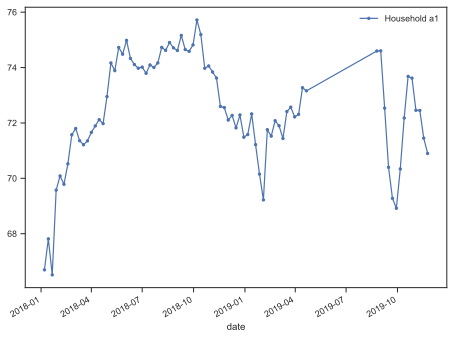

In [66]:
fig, ax = plt.subplots()
a1_df.plot(x='date', y='t_unit', label='Household a1', style='.-', fig=fig, ax=ax);

And here is how you can add the temperature of another unit:

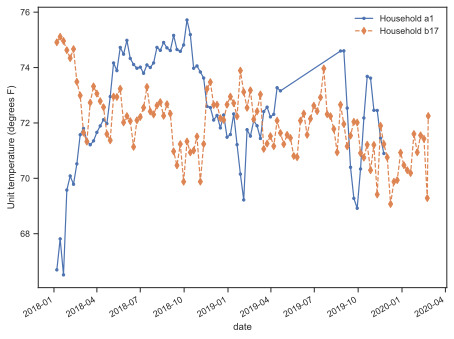

In [67]:
fig, ax = make_full_width_fig()
a1_df.plot(x='date', y='t_unit', label='Household a1', style='.-', ax=ax)
b17_df.plot(x='date', y='t_unit', label='Household b17', style='d--', ax=ax)
ax.set_ylabel('Unit temperature (degrees F)')
save_for_book(fig, 'ch6.fig2');

We confirm that 

### Questions

+ In the figure of `t_unit` vs `date` above, add data from household `c36`.
+ For households `a1`, `b17` and `c36` plot `hvac` as a function of the `date`.

So far we manually extracted the data we needed for each unit.
Now, I will show you how you can do it for as many units as you like using a `for` loop.
Let's say we have a list of households we want to plot.
We need to plot the data for each household using a different marker.
How can we loop over pairs of household names and markers?
The most elegant way to do this is by using the `zip` function:

In [68]:
households = ['a1', 'a2', 'a3', 'a4', 'a5']
markers = ['o', 's', 'd', 'p', 'x']
for h, m in zip(households, markers):
    print(h, m)

a1 o
a2 s
a3 d
a4 p
a5 x


The `zip` function takes two lists and returns a list of pairs. Actually, you get back a object called an \emph{iterator}, but you can think of it as a list of pairs.
Each pair contains one element from the first list and one from the second.
Let's redo our scatter plot for a list of households:

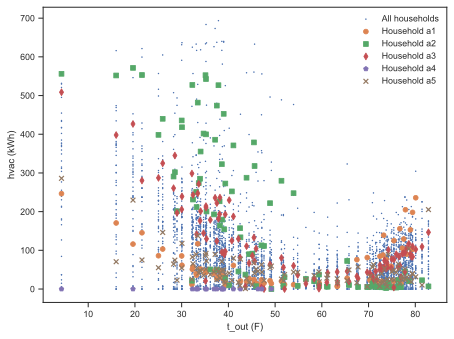

In [69]:
fig, ax = make_full_width_fig()
ax.scatter(df['t_out'], df['hvac'], label='All households', s=0.5)
households = ['a1', 'a2', 'a3', 'a4', 'a5']
markers = ['o', 's', 'd', 'p', 'x']
for h, m in zip(households, markers):
    df_tmp = df[df['household'] == h]
    ax.scatter(df_tmp['t_out'], df_tmp['hvac'], label='Household ' + h, marker=m)
ax.set_xlabel('t_out (F)')
ax.set_ylabel('hvac (kWh)')
plt.legend(loc='best')
save_for_book(fig, 'ch6.fig3');

### Questions

+ Modify the code above so that you plot the scatter plot for the first 5 of the `c??` households.
+ For the same households as above, plot `hvac` as a function of `date`.

## Extract rows that satisfy more complicated boolean expressions

Let's say that we want to see how the selection of `t_unit` (temperature setpoint) affects `hvac` (energy consumption) during the heating season.
We are on heating season for sure when the external temperature is smaller than 55 degrees F.
So, we need to extract all the rows with `df['t_out'] < 55`.

In [70]:
df_heating = df[df['t_out'] < 55]
df_heating.round(2)

household       date  score  t_out  t_unit    hvac
0           a1 2018-01-07  100.0   4.28   66.69  246.47
1          a10 2018-01-07  100.0   4.28   66.36    5.49
2          a11 2018-01-07   58.0   4.28   71.55  402.09
3          a12 2018-01-07   64.0   4.28   73.43  211.69
4          a13 2018-01-07  100.0   4.28   63.92    0.85
...        ...        ...    ...    ...     ...     ...
5643       c44 2020-02-25   59.0  43.64   76.49   19.14
5644       c45 2020-02-25   87.0  43.64   71.17   30.79
5646       c47 2020-02-25   97.0  43.64   68.60    5.34
5647       c48 2020-02-25   92.0  43.64   73.43   18.04
5649       c50 2020-02-25   59.0  43.64   77.72   14.41

[2741 rows x 6 columns]

Now, we are going to draw the scatter plot between `t_out` and `hvac`, but we are going to color the points according to the unit temperature `t_unit`.
Let's first pick the rows with `t_unit` between 70 and 72 degrees F.

In [71]:
df_heating_70to72 = df_heating[df_heating['t_unit'] >= 70 and
                               df_heating['t_unit'] < 72]
df_heating_70to72.head()

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

The problem here is that on the left and on the right of the logical `and` operator you have arrays of booleans not just booleans.
Python does not know what to do with them.
The correct operator to use to represent logical `AND` in this situation is `&` (which you can also read as `AND`).
Let's try again.
This time we are going to get a really big error message.
I'm going to hide it.

In [72]:
df_heating_70to72 = df_heating[df_heating['t_unit'] >= 70 &
                               df_heating['t_unit'] < 72]
df_heating_70to72.head()

TypeError: Cannot perform 'rand_' with a dtyped [float64] array and scalar of type [bool]

The problem here is the order in which the expression is evaluated. 
The operator `&` has a special meaning in Python (we are not going to get into it) and it has high priority.
So, python tries to evaluate first `68 & df_heating['t_unit']` which is meanigless.
What needs to happen here is that is should first evaluate `df_heating['t_unit'] >= 68` to get an array of booleans, then evaluate `df_heating['t_unit'] < 70` to get another array of booleans, and the use `&` to logically compare the arrays pointwise.
We can enforce this order using parentheses.
Whatever Python expression is enclosed in parentheses will be evaluated first.
So, here is the correct way to do it:

In [73]:
df_heating_70to72 = df_heating[(df_heating['t_unit'] >= 70) &
                               (df_heating['t_unit'] < 72)]
df_heating_70to72.head().round(2)

household       date  score  t_out  t_unit    hvac
2        a11 2018-01-07   58.0   4.28   71.55  402.09
17       b18 2018-01-07   87.0   4.28   70.61  368.15
25       b26 2018-01-07   97.0   4.28   70.01   36.65
29       b30 2018-01-07   99.0   4.28   71.42   23.68
34       c35 2018-01-07   96.0   4.28   70.56  349.03

Here is the plot:

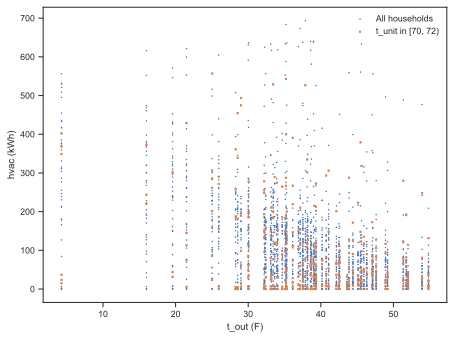

In [74]:
fig, ax = make_full_width_fig()
ax.scatter(df_heating['t_out'], df_heating['hvac'], label='All households', s=0.5)
ax.scatter(df_heating_70to72['t_out'], df_heating_70to72['hvac'], 
           label='t_unit in [70, 72)', marker='s', s=2)
ax.set_xlabel('t_out (F)')
ax.set_ylabel('hvac (kWh)')
plt.legend(loc='best')
save_for_book(fig, 'ch6.fig4');

We see that the units with `t_unit` between 70 and 72 degrees F tend to consume less energy. There are some outliers, but the trend is clear. 
What can explain the outliers though?
How can two households with the same internal temperature `t_unit` have very different energy consumption? 
There are other variables here that we are not observing.
For example, the location of the unit in the building.
A unit that is at the corner of the building will have different heat loss than a unit that is in the middle of the building.
Another explanation is that the occupants may be opening the windows more often in one of the appartments.
Such variables are called \emph{confounding variables}.
You should always be on the lookout for them.

Let's demonstrate a logical-or for selecting rows.
As you may have guessed `or` does not work.
We need to use the operator `|`.
And yes, we need to enclose everything in parentheses.
Let's select the entries that highlight wasteful energy consuming behavior.
That would be units that have a very high `t_unit` (say above 78 degrees F) during heating or a very low `t_unit` during cooling (say below 70 degrees F).
Let's see how much energy they consume.

In [75]:
df_bad_behavior = df[((df['t_out'] < 55) & (df['t_unit'] > 78)) |
                     ((df['t_out'] >= 55) & (df['t_unit'] < 70))]
df_bad_behavior.head().round(2)

household       date  score  t_out  t_unit    hvac
15         a9 2018-01-07   39.0   4.28   78.71  495.23
22        b23 2018-01-07   44.0   4.28   78.62  359.17
65         a9 2018-01-14   41.0  33.44   78.56  321.83
72        b23 2018-01-14   43.0  33.44   78.68  197.92
115        a9 2018-01-21   41.0  19.58   78.57  431.24

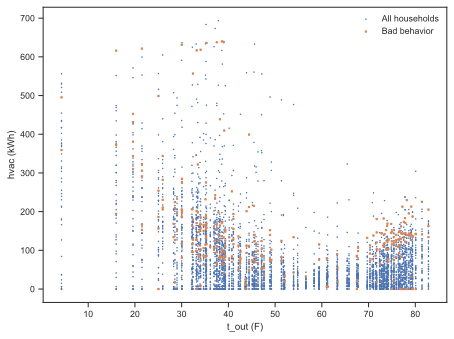

In [76]:
fig, ax = make_full_width_fig()
ax.scatter(df['t_out'], df['hvac'], label='All households', s=0.5)
ax.scatter(df_bad_behavior['t_out'], df_bad_behavior['hvac'], 
           label='Bad behavior', marker='s', s=2)
ax.set_xlabel('t_out (F)')
ax.set_ylabel('hvac (kWh)')
plt.legend(loc='best')
save_for_book(fig, 'ch6.fig5');

Notice that they are some entries that exhibit bad behavior without being penalized with excessive energy consumption.
Can you think of a confounding variable that could explain this?
Here is what is happening:
+ Units that are at the corners of the building expose at least two sides to the external environment.
+ Units that are on the top floor expose at least two sides to the external environment.
+ Units that are at a corner and on the top floor expose three sides to the external environment.
+ The rest of the units expose a single side to the external environment.
The first three groups (and especially the third group) are loosing a lot of energy to the environment and their energy consumption will in general be higher.
The final group is basically insulated from the environment and on top of that they may be getting heat energy from their neighbors.
Behaving badly in a top floor, corner unit will be reflected on your energy bill.
Behaving badly in an insulated unit may have no effect on your energy bill.

Let's end with logical-not for selecting rows.
Say we wanted to negate the previous selection so that we highlight all those who behaved well.
For this, you use the `~` operator in front of the logical expression you want to negate.
Like this:

In [77]:
df_good_behavior = df[~(((df['t_out'] < 55) & (df['t_unit'] > 78)) |
                     ((df['t_out'] >= 55) & (df['t_unit'] < 70)))]
df_good_behavior.head().round(2)

household       date  score  t_out  t_unit    hvac
0        a1 2018-01-07  100.0   4.28   66.69  246.47
1       a10 2018-01-07  100.0   4.28   66.36    5.49
2       a11 2018-01-07   58.0   4.28   71.55  402.09
3       a12 2018-01-07   64.0   4.28   73.43  211.69
4       a13 2018-01-07  100.0   4.28   63.92    0.85

Again, pay attention to the parentheses because they are critical for the correct evaluation of the expression.

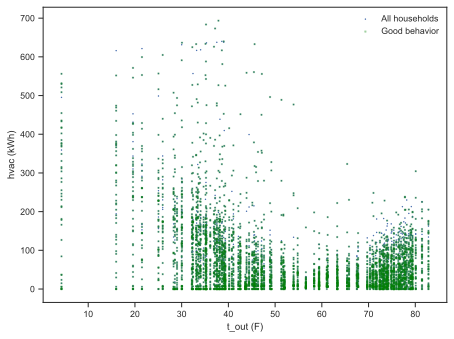

In [78]:
fig, ax = make_full_width_fig()
ax.scatter(df['t_out'], df['hvac'], label='All households', s=0.5)
ax.scatter(df_good_behavior['t_out'], df_good_behavior['hvac'], 
           label='Good behavior', color='green', marker='s', s=2, alpha=0.25)
ax.set_xlabel('t_out (F)')
ax.set_ylabel('hvac (kWh)')
plt.legend(loc='best');

### Questions 

+ The final histogram highlighting units with good behavior is not very useful because the range of `t_unit` temperatures we considered as good is too wide. Rerun the code block above using a narrower range of temperatures. Say a bad choice for heating is `t_unit` > 72 and a bad for cooling is `t_unit` < 75. Then, redo the scatter plot.